# Stock Market Forecasting-Time Series Forecasting ARIMA
The aim of the project is to analysing the historical stock market data and making Time Series Forecasting using ARIMA model.

Data source: Dow Jones Historical Data from year 2000
https://finance.yahoo.com/quote/%5EDJI/history?period1=946684800&period2=1589932800&interval=1d&filter=history&frequ

## 1. Improt Stock Data for Analysis

In [1]:
import os
os.getcwd()
os.listdir()

['Time Series Forecasting- ARIMA.ipynb',
 'DJI.csv',
 'Stock Market Forecasting-Time Series Forecasting ARIMA.ipynb',
 'Time Series Forecasting- ARIMA.slides.html',
 '.ipynb_checkpoints']

In [29]:
import pandas as pd

#Read data from csv and set date as index for further time series analysis
df=pd.read_csv('DJI.csv',parse_dates=['Date'],index_col='Date')
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-13,23702.160156,23708.900391,23067.640625,23247.970703,23247.970703,469950000
2020-05-14,23049.060547,23630.859375,22789.619141,23625.339844,23625.339844,472700000
2020-05-15,23454.830078,23730.080078,23354.150391,23685.419922,23685.419922,491510000
2020-05-18,24059.980469,24708.539063,24059.980469,24597.369141,24597.369141,484190000
2020-05-19,24577.480469,24599.500000,24202.960938,24206.859375,24206.859375,374100000


## 2. Data Cleaning

In [30]:
# Remove data since year 2020
df=df[:'2019-12-31']

In [31]:
# Trim the data set and keep 'Close' for analysis
df.drop(axis=1,columns=['Open','High','Low','Adj Close'],inplace=True)

In [32]:
df.tail()

,Close,Volume
Date,,
2019-12-24,28515.449219,86150000
2019-12-26,28621.390625,155970000
2019-12-27,28645.259766,182280000
2019-12-30,28462.140625,181600000
2019-12-31,28538.439453,193340000


## 3. Check Stationary of the Time Series

* **Plotting Rolling Statistics**
* **Dickey-Fuller Test**: The null hypothesis is that the TS is non-stationary. The test results comprise of a **Test Statistic** and some **Critical Values** for difference confidence levels. 
   
   If the ‘Test Statistic’ **<** ‘Critical Value’, reject the null hypothesis, TS: **Stationary**
   
   If the ‘Test Statistic’ **>** ‘Critical Value’, accept the null hypothesis,TS: **Non Stationary**

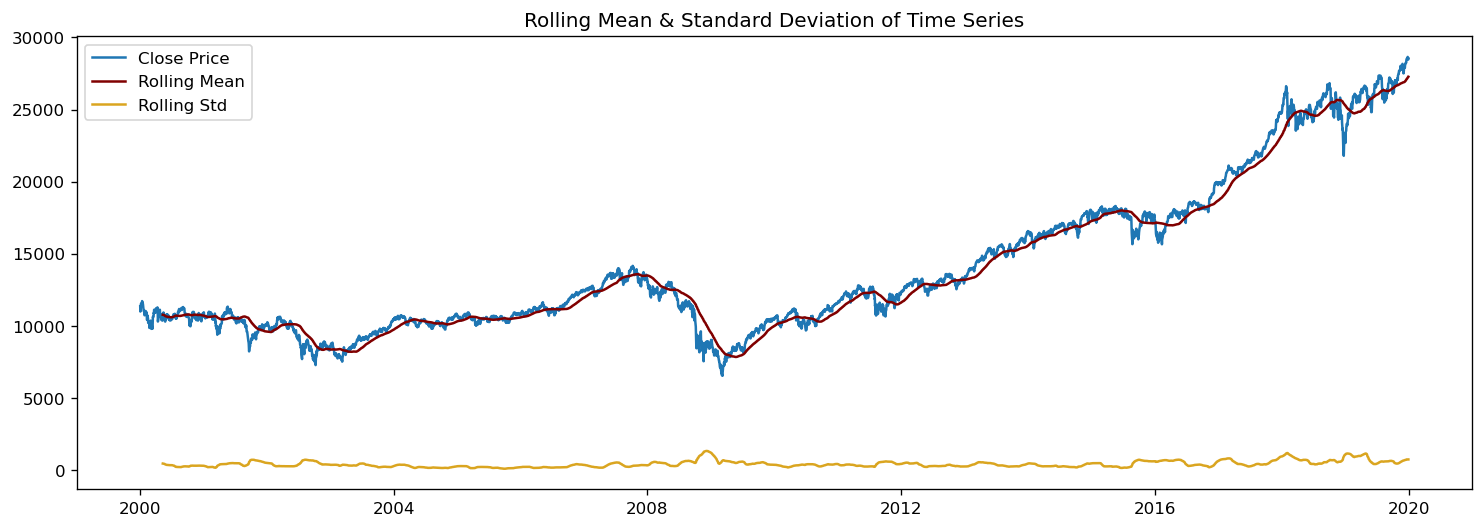

In [33]:
#Unit root stationary tests
#get rolling statistics
ts=df['Close']
rollingmean = ts.rolling(window=92).mean()
rollingstd =  ts.rolling(window=92).std()

#Plot rolling statistics:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(15,5))
plt.plot(ts,label='Close Price')
plt.plot(rollingmean, color='maroon', label='Rolling Mean')
plt.plot(rollingstd, color='goldenrod', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation of Time Series')
plt.show()

#### From what we observed from the plot, the time series is non stationary with obvious trends and fluctuations

In [7]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

def adf_test(data):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value 
    return print(dfoutput)

adf_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                    1.497923
p-value                           0.997517
#Lags Used                       19.000000
Number of Observations Used    5011.000000
Critical Value (1%)              -3.431656
Critical Value (5%)              -2.862117
Critical Value (10%)             -2.567077
dtype: float64


#### The result shows the test statistic(1.497923) is greater than all of the critical values, which aligns with our previous conclusion: the time series is non stationary.

## 4. To Make the Non-stationary Time Series Stationary

4 different methods were practiced:

**(1) Differencing**

Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trend and seasonality

Difference id performed by substracting the previous observation from the current observation

difference(t)= observation(t)-observation(t-1)

**(2) Log transform**

Taking the log of the dependent variable is as simple way of lowering the rate at which rolling mean increases.

**(3) Moving average**

Take a **weighted moving average** where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor.

**(4) Decomposition**

Modeling trend and seasonality and removing them from the model.

### (1) **Differencing**

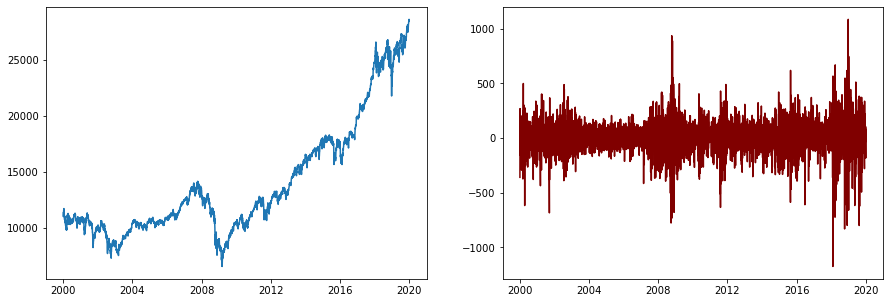

In [8]:
# Differencing
ts_diff=ts.diff()
fig=plt.figure(figsize=(15,5))
ax1=fig.add_subplot(121)
ax1.plot(ts)
ax2=fig.add_subplot(122)
ax2.plot(ts_diff,color='maroon')
plt.show()

In [9]:
#Apply Dickey-Fuller test on differenced time series:
ts_diff.dropna(inplace=True)
adf_test(ts_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.729720e+01
p-value                        5.657469e-30
#Lags Used                     1.800000e+01
Number of Observations Used    5.011000e+03
Critical Value (1%)           -3.431656e+00
Critical Value (5%)           -2.862117e+00
Critical Value (10%)          -2.567077e+00
dtype: float64


#### We can see the test statistic is improving from 1.497923 to -1.729720, but still greater than critical values.
To improve the result, it is worth to try several rounds of differencing.

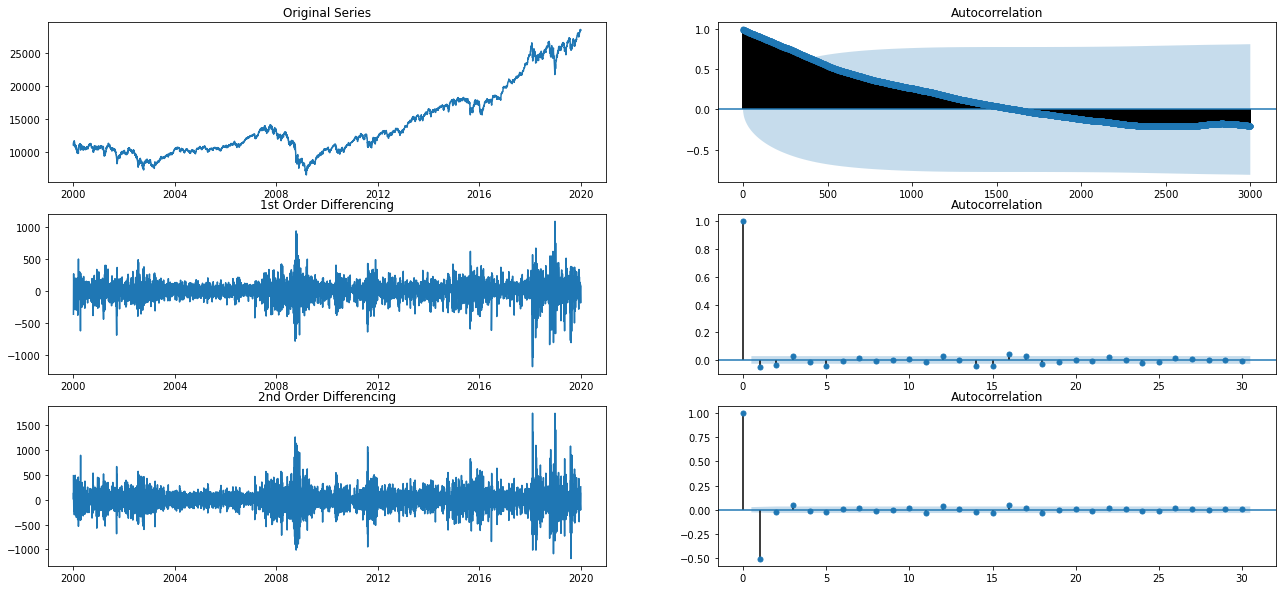

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For each change(originl,1st,2nd differencing) plot the ACF to determine the best order of differencing.
# Original Series
fig=plt.figure(figsize=(22,10))
ax1=fig.add_subplot(321)
ax1.plot(ts);
ax1.set_title('Original Series')
ax2=fig.add_subplot(322)
plot_acf(ts,ax=ax2,lags=3000);

# 1st Differencing
ax3=fig.add_subplot(323)
ax3.plot(ts.diff());
ax3.set_title('1st Order Differencing')
ax4=fig.add_subplot(324)
plot_acf(ts.diff().dropna(), ax=ax4,lags=30)

# 2nd Differencing
ax5=fig.add_subplot(325)
ax5.plot(ts.diff().diff());
ax5.set_title('2nd Order Differencing')
ax6=fig.add_subplot(326)
plot_acf(ts.diff().diff().dropna(), ax=ax6,lags=30)
plt.show()

#### From what we observed from the Autocorrelation plot, 1st order differencing is enough for the practise.

### (2) **Log Transform**

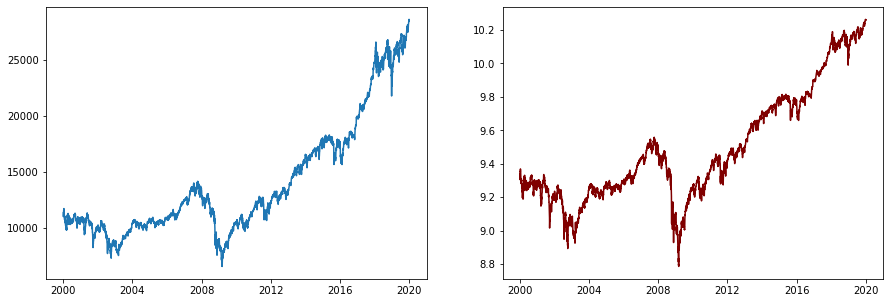

In [11]:
# Log transform
import numpy as np
ts_log = np.log(ts)
fig=plt.figure(figsize=(15,5))
ax1=fig.add_subplot(121)
ax1.plot(ts)
ax2=fig.add_subplot(122)
ax2.plot(ts_log,color='maroon')
plt.show()

In [12]:
#Apply Dickey-Fuller test on log tramformed time series:
ts_log.dropna(inplace=True)
adf_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                    0.237834
p-value                           0.974306
#Lags Used                       18.000000
Number of Observations Used    5012.000000
Critical Value (1%)              -3.431655
Critical Value (5%)              -2.862117
Critical Value (10%)             -2.567077
dtype: float64


#### The test result 0.237834 is greater than critical values, which lead to further work. Here I combine moving average to existing log transformation work.

### (3) **Smoothing-Moving average**

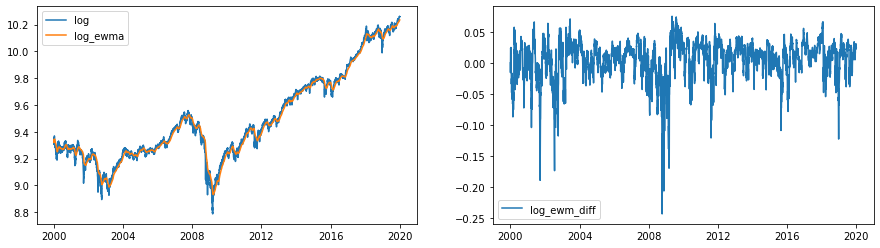

In [13]:
# Apply weighted moving average on log transform
ts_log_ewma=ts_log.ewm(alpha=0.04).mean()

# Apply differencing on log & log_WMA
ts_log_ewm_diff=ts_log-ts_log_ewma

# Plot log, log_wma, log_wma_diff to view the result
fig=plt.figure(figsize=(15,4))
ax1=fig.add_subplot(1,2,1)
ax1.plot(ts_log,label='log')
ax1.plot(ts_log_ewma,label='log_ewma')
plt.legend(loc='best')

ax2=fig.add_subplot(1,2,2)
ax2.plot(ts_log_ewm_diff, label='log_ewm_diff')
plt.legend(loc='best')

plt.show()

In [14]:
#Apply Dickey-Fuller test on time series:
adf_test(ts_log_ewma)

Results of Dickey-Fuller Test:
Test Statistic                    0.533045
p-value                           0.985844
#Lags Used                       19.000000
Number of Observations Used    5011.000000
Critical Value (1%)              -3.431656
Critical Value (5%)              -2.862117
Critical Value (10%)             -2.567077
dtype: float64


#### This test statistic(0.533045) has even lesser variation compared to log one (0.237834)

In [15]:
#Apply Dickey-Fuller test on time series:
ts_log_ewm_diff.dropna(inplace=True)
adf_test(ts_log_ewm_diff)

Results of Dickey-Fuller Test:
Test Statistic                -9.425831e+00
p-value                        5.350079e-16
#Lags Used                     1.800000e+01
Number of Observations Used    5.012000e+03
Critical Value (1%)           -3.431655e+00
Critical Value (5%)           -2.862117e+00
Critical Value (10%)          -2.567077e+00
dtype: float64


#### This test statistic(-9.425831) is smaller than the 1% critical value(-3.431655), which is better than the previous case.

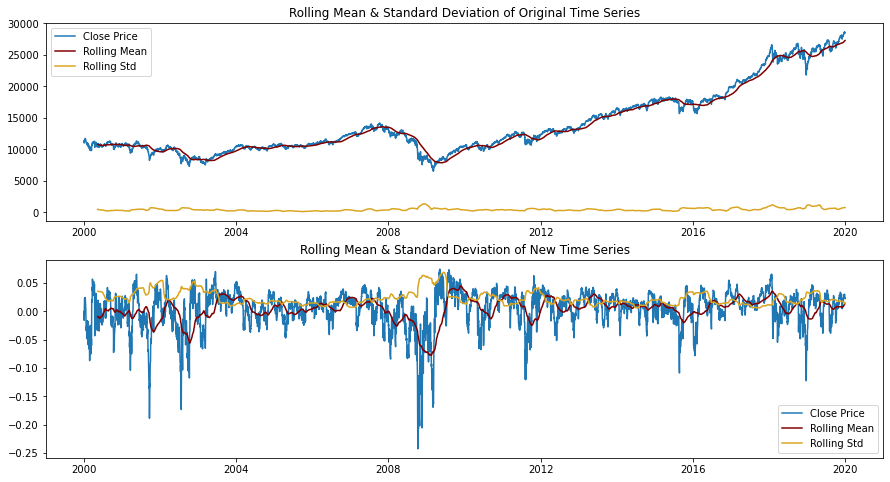

In [16]:
#Unit root stationary tests
#get rolling statistics
rollingmean = ts.rolling(window=92).mean()
rollingstd =  ts.rolling(window=92).std()

new_rollingmean = ts_log_ewm_diff.rolling(window=92).mean()
new_rollingstd =  ts_log_ewm_diff.rolling(window=92).std()

#Plot rolling statistics:
fig=plt.figure(figsize=(15,8))
ax1=fig.add_subplot(2,1,1)
ax1.plot(ts,label='Close Price')
ax1.plot(rollingmean, color='maroon', label='Rolling Mean')
ax1.plot(rollingstd, color='goldenrod', label = 'Rolling Std')
ax1.legend(loc='best')
ax1.set_title('Rolling Mean & Standard Deviation of Original Time Series')

ax2=fig.add_subplot(2,1,2)
ax2.plot(ts_log_ewm_diff,label='Close Price')
ax2.plot(new_rollingmean, color='maroon', label='Rolling Mean')
ax2.plot(new_rollingstd, color='goldenrod', label = 'Rolling Std')
ax2.legend(loc='best')
ax2.set_title('Rolling Mean & Standard Deviation of New Time Series')

plt.show()

#### This TS has even lesser variations in mean and standard deviation in magnitude. The time series is fairly stationary now.

### (4) **Decomposition**
Split out trend and seasonality and removing them from the model.

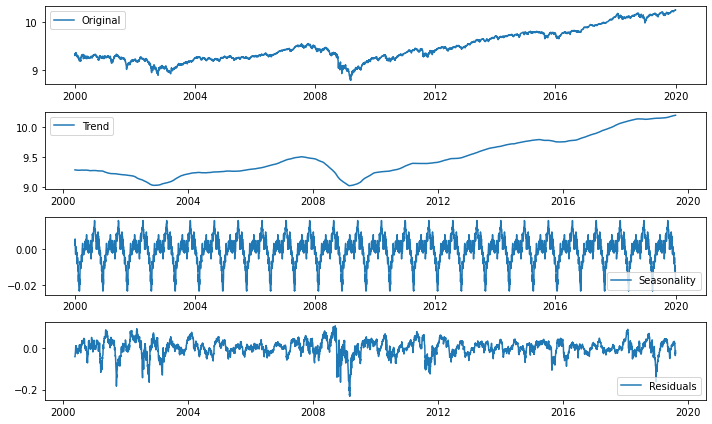

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log,period=200)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

#Plot the decomposition
fig=plt.figure(figsize=(10,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

In [18]:
#Apply Dickey-Fuller test on time series:

ts_residual=residual.dropna()
adf_test(ts_residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.734533e+00
p-value                        8.822128e-17
#Lags Used                     3.000000e+01
Number of Observations Used    4.800000e+03
Critical Value (1%)           -3.431713e+00
Critical Value (5%)           -2.862142e+00
Critical Value (10%)          -2.567091e+00
dtype: float64


#### The test statistic(-9.734533) significantly lower than the 1% critical value (-3.431713). So this TS is very close to stationary.

## 5. Forecasting -  ARIMA Model

#### ARIMA= Autoregressive(AR) + Integrated + Moving Average(MA)

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

**1. Auto-regression(AR)**

Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

1.1 **Parameter: p**: number of autoregressive terms (AR order)

1.2 **Partial Autocorrelation Function (PACF)** PACF expresses the correlation between observations made at two points in time while accounting for any influence from other data points.

determine the optimal number of terms to use in the AR model.

1.3 Codition/Assumption:Stationary dataset

**2. Integration (I)**

The reverse of differencing

2.1 **Parameter: d**: number of nonseasonal differences (differencing order)

2.2 **Autocorrelation function (ACF)** determine the optimal number of differncing


**3. Moving Average (MA)**

Moving average(MA) removes random movements from a time series. It helps smooth out value movement by filtering out the 'noise' from random short-term value fluctuations

3.1 **Parameter: q**: size of the moving average window(MA order)

3.2 **Autocorrelation function (ACF)** The correlation between the observations at the current point in time and the observations at all previous points in time.

determine the optimal number of MA terms




### 5.1 Using PACF to determine p for AR

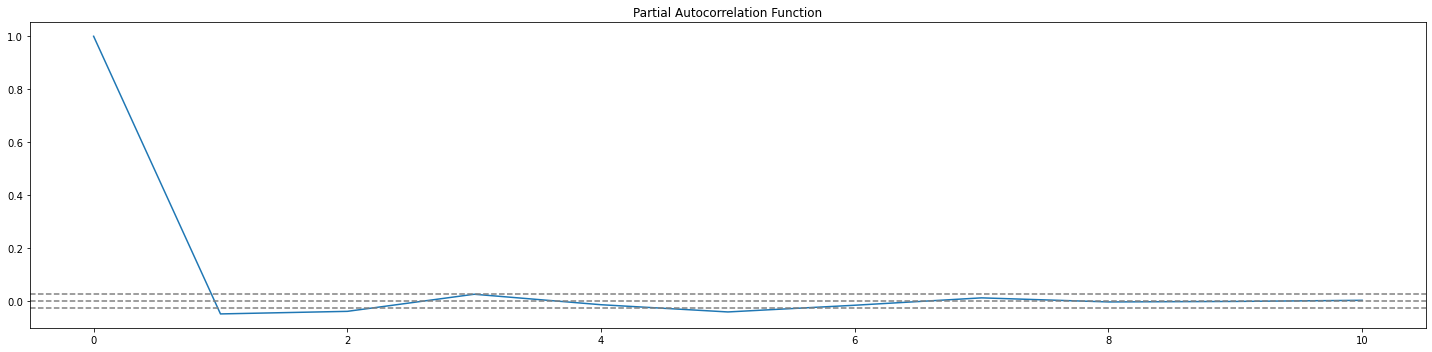

In [17]:
#PACF plots:
from statsmodels.tsa.stattools import pacf
lag_pacf = pacf(ts.diff().dropna(), nlags=10, method='ols')
#Plot PACF:
plt.figure(figsize=(20,5))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts.diff().dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts.diff().dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#### p =1 – The lag value where the PACF chart crosses the upper confidence interval for the first time.

### 5.2 Using ACF to determine q for MA, d for I

Text(0.5, 1.0, 'Autocorrelation Function')

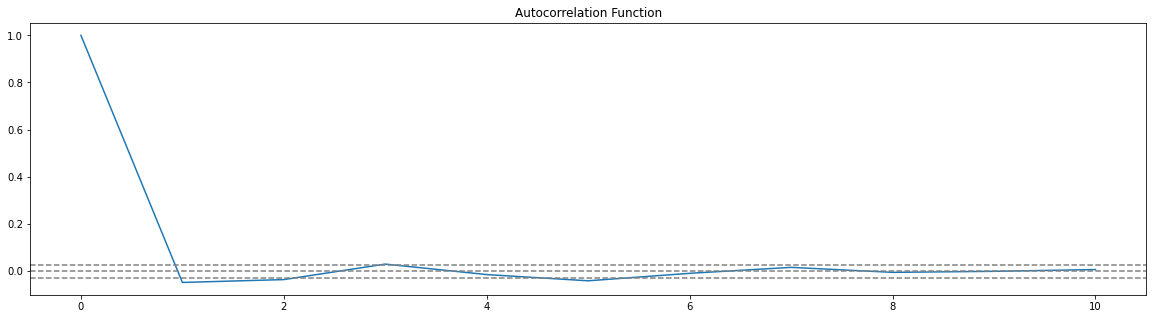

In [18]:
#Plot ACF:
from statsmodels.tsa.stattools import acf

lag_acf = acf(ts.diff().dropna(), nlags=10, fft=False)

plt.figure(figsize=(20,5))
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts.diff().dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts.diff().dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#### q=1 – The lag value where the ACF chart crosses the upper confidence interval for the first time.
#### d=1 - The lag value where the ACF chart crosses zero for the first time

### 5.3 Build ARIMA Model

In [89]:
# Build Model
from statsmodels.tsa.arima_model import ARIMA

# 1,1,1 ARIMA Model
train=ts['2019-01-1':'2019-10-31']
test=ts['2019-11-1':]

model = ARIMA(train, order=(2, 1, 2))  
model_fit= model.fit(disp=0)  

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/apple/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [90]:
#Test Model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  210
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1421.358
Method:                       css-mle   S.D. of innovations            209.764
Date:                Thu, 03 Dec 2020   AIC                           2854.716
Time:                        16:37:36   BIC                           2874.799
Sample:                             1   HQIC                          2862.835
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            14.5939      5.305      2.751      0.006       4.196      24.992
ar.L1.D.Close     0.7052      0.608      1.160      0.246      -0.486       1.897
ar.L2.D.Close     0.2569      0.583     

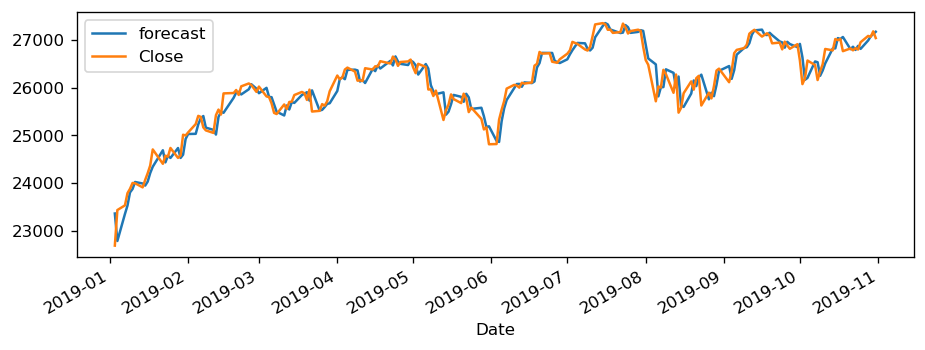

In [84]:
model_fit.plot_predict(dynamic=False)
plt.show()

#When you set dynamic=False the in-sample lagged values are used for prediction.
#That is, the model gets trained up until the previous value to make the next prediction. 
#This can make the fitted forecast and actuals look artificially good.

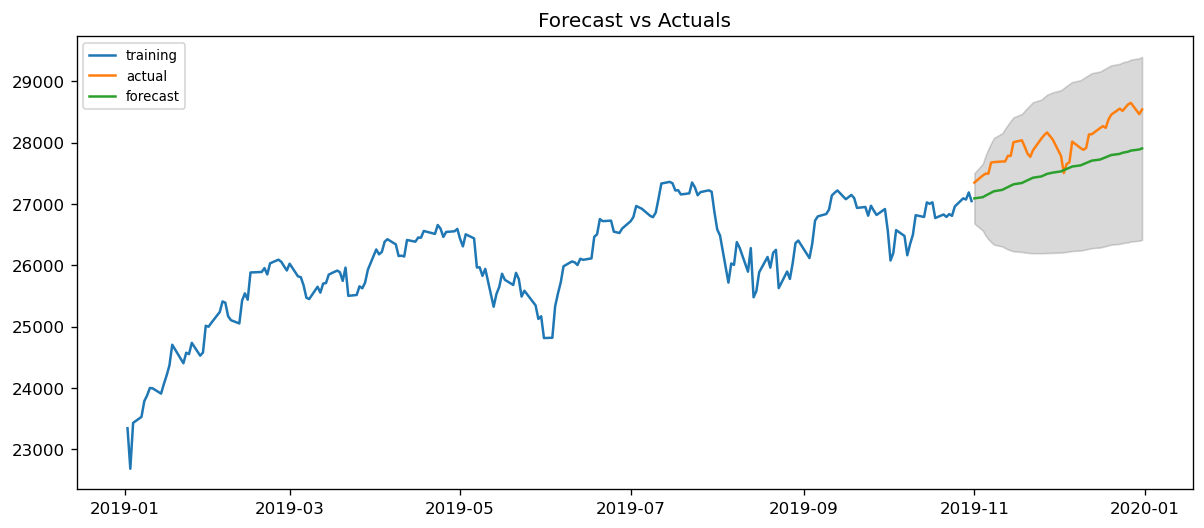

In [91]:


# Forecast
fc, se, conf = model_fit.forecast(41, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## 6. Measure Moldel Performance

**1. Mean Forecast Error (MFE)**

-Measure of the average deviation of forecasted values from actual ones

-Shows the direction of error as Forecast Bias

-Desirable that the MFE is as close to 0 as possible

**2. Mean Absolute Error (MAE)**

-Meaures the average absolute deviation of forecasted values from actial ones

-MAEdose not provide any idea about the direction of errors

-Fore a good forcast, the obtained MAE should be as close to 0 as possible

**3. Mean Squared Error(MSE)**

-Measure of average squared deviation of forecasted values

-MSE gives an overall idea of the error occurred during forcasting

-MSE is sensitive to the change of scale and data transformations

In [92]:
from sklearn.metrics import mean_squared_error

def forecast_accuracy(forecast, actual):
    mfe = np.mean(forecast - actual)             # MFE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mse = mean_squared_error(forecast,actual) # MSE
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    return({'mfe':mfe,'mae': mae, 'mse': mse,'mape':mape})

forecast_accuracy(fc, test)

{'mfe': -468.69528678970147,
 'mae': 470.9838231810568,
 'mse': 255584.65631850032,
 'mape': 0.016771284018891885}

#### Around 1.9% MAPE implies the model is about 98.1% accurate in predicting the next 41 observations.